<a href="https://colab.research.google.com/github/tizbid/Datathon/blob/master/Gender_Determination_by_Morphometry_of_Eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

Unzipping...Done.


We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [2]:
import pandas as pd                                                                           # Data analysis and manipultion tool
import numpy as np                                                                            # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                                                       # Deep Learning Tool
from tensorflow.keras.models import Sequential                                                # For buidling Sequential models
from tensorflow.keras.layers import Activation,Dense,Dropout,Conv2D,Flatten,MaxPooling2D       # Layer parameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os                                                                                     # OS module in Python provides a way of using operating system dependent functionality
import cv2                                                                                    # Library for image processing
from sklearn.model_selection import train_test_split                                          # For splitting the data into train and validation set
from random import shuffle
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


## Loading and preparing training data


In [3]:
labels = pd.read_csv("/content/content/eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, '/content/content/eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
print(train_data.head())
print(len(train_data))

      filename                                          filepaths   label
0  Image_1.jpg  /content/content/eye_gender_data/train/Image_1...    male
1  Image_2.jpg  /content/content/eye_gender_data/train/Image_2...  female
2  Image_3.jpg  /content/content/eye_gender_data/train/Image_3...  female
3  Image_4.jpg  /content/content/eye_gender_data/train/Image_4...  female
4  Image_5.jpg  /content/content/eye_gender_data/train/Image_5...    male
9220


In [4]:
data = []     # initialize an empty numpy array
image_size = 100     # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):
  
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  data.append([new_img_array, train_data['label'][i]])

In [5]:
data[0]


[array([[188, 188, 189, ..., 176, 175, 175],
        [189, 189, 188, ..., 174, 173, 172],
        [190, 189, 188, ..., 168, 167, 167],
        ...,
        [133, 137, 144, ..., 168, 167, 166],
        [134, 138, 145, ..., 165, 164, 163],
        [135, 139, 146, ..., 163, 162, 162]], dtype=uint8), 'male']

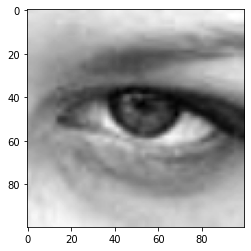

In [6]:
plt.imshow(data[225][0],cmap='gray')
plt.show()

## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [7]:
#convert labels from categorical to numerical values
train_data['label'].replace(['male','female'],[1,0],inplace=True)



In [8]:
# Load Training Data

def create_training_data():
  training_data = []
  for i in range(len(train_data)):
    
    img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
    training_data.append([np.array(new_img_array), np.array(train_data['label'][i])])

  #shuffle(training_data)
  np.save('train_data.npy', training_data)
  return training_data

training_data = create_training_data()



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [9]:
training_data[0]

[array([[188, 188, 189, ..., 176, 175, 175],
        [189, 189, 188, ..., 174, 173, 172],
        [190, 189, 188, ..., 168, 167, 167],
        ...,
        [133, 137, 144, ..., 168, 167, 166],
        [134, 138, 145, ..., 165, 164, 163],
        [135, 139, 146, ..., 163, 162, 162]], dtype=uint8), array(1)]

In [10]:
#features and labels
X = []
y = []

In [11]:
for features,label in training_data:
  X.append(features)
  y.append(label)


X = np.array(X).reshape(-1,image_size, image_size, 1)
y = np.array(y)


In [12]:
print(X.shape,y.shape)

(9220, 100, 100, 1) (9220,)


## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [13]:
# define input shape
INPUT_SHAPE = (image_size,image_size, 1)

# define sequential model
model = Sequential()

# define conv-pool layers - set 1
model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))


# define conv-pool layers - set 2
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(Flatten())

# add dense layers with some dropout
#model.add(Dense(256, activation='relu'))


model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(512, activation='relu'))

# add output layer
model.add(Dense(1, activation='sigmoid'))

# view model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4333824   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [14]:
#save Model
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [18]:
#Load back model for use in validation 
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4333824   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [19]:
# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Validate the model


In [20]:
X_train= X/ 255.0                               # Normalize training data
y_train = y
#es_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,verbose=1) #setup earlingstopping callbacks

history = model.fit(X_train,y_train,batch_size=35,epochs=10, validation_split = 0.2,verbose=1)

Epoch 1/10
211/211 [==============================] - 34s 10ms/step - loss: 0.5147 - accuracy: 0.7294 - val_loss: 0.4212 - val_accuracy: 0.8026
Epoch 2/10
211/211 [==============================] - 2s 9ms/step - loss: 0.3516 - accuracy: 0.8468 - val_loss: 0.3050 - val_accuracy: 0.8693
Epoch 3/10
211/211 [==============================] - 2s 8ms/step - loss: 0.2999 - accuracy: 0.8743 - val_loss: 0.2900 - val_accuracy: 0.8802
Epoch 4/10
211/211 [==============================] - 2s 8ms/step - loss: 0.2511 - accuracy: 0.8929 - val_loss: 0.2878 - val_accuracy: 0.8867
Epoch 5/10
211/211 [==============================] - 2s 8ms/step - loss: 0.2102 - accuracy: 0.9140 - val_loss: 0.2768 - val_accuracy: 0.8970
Epoch 6/10
211/211 [==============================] - 2s 8ms/step - loss: 0.1869 - accuracy: 0.9241 - val_loss: 0.2659 - val_accuracy: 0.8986
Epoch 7/10
211/211 [==============================] - 2s 8ms/step - loss: 0.1443 - accuracy: 0.9417 - val_loss: 0.2737 - val_accuracy: 0.9073
Epoc

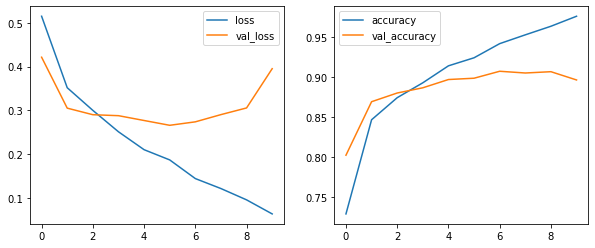

In [21]:
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);                                                                                                                                       

## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

#### Load Test Set
Load the test data on which final submission is to be made.

In [22]:
test_dir = '/content/content/eye_gender_data/test/'

In [23]:
#Load Test Data

def create_Test_data():
  testing_data = []
  for img in os.listdir(test_dir):
    path = os.path.join(test_dir,img)
    #img_num = img.split('.')[0]
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
    new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
    testing_data.append([np.array(new_img_array)])

  shuffle(testing_data)
  np.save('test_data.npy', testing_data)
  return testing_data

testing_data = create_Test_data()


## Data Pre-processing on test_data


In [24]:
test_images = np.array(testing_data).reshape(-1,image_size, image_size, 1)

In [25]:
X_test= test_images/ 255.0 

### Make Prediction on Test Dataset
Time to make a submission!!!

In [26]:
test_data_predictions = model.predict(X_test)

In [27]:
def get_predictions():
  predictions = []
  for img in test_data_predictions:
    if img > 0.5:
      predictions.append('male')
    else:
      predictions.append('female')
  
  return predictions 

predictions = get_predictions()


In [29]:
predictions [:5]

['female', 'female', 'male', 'male', 'female']

### Save prediction results locally via colab notebook


In [ ]:
res = pd.DataFrame({'label': predictions})  
res.to_csv("submission.csv", index = False) 

# To download the csv file locally
from google.colab import files        
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Well Done! 👍**
You are all set to make a submission. Let's head to the **[challenge page](https://dphi.tech/challenges/4-week-deep-learning-online-bootcamp-final-assignment-sex-determination-by-morphometry-of-eyes/144/submit)** to make the submission.